In [4]:
import numpy as np
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from loadmodules import *
import os

In [1]:
def weighted_quantiles(values, weights, quantiles=0.5):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [2]:
def get_metallicity_functions(simulation, age_cut=10., nbins=10):
    sf = load_subfind(127, dir=simulation+'/output/')
    s = gadget_readsnap(127, snappath=simulation+'/output/', subfind=sf, applytransformationfacs=True, hdf5=True, loadonlyhalo=0, loadonlytype=[4])

    s.calc_sf_indizes(sf)
    rot_matrix = s.select_halo(sf)

    s.data['pos'] *= 1e3 # in kpc
    s.data['mass'] *= 1e10 # change mass to solar masses
    s.data['mclt'] *= 1e10
    s.data['imcl'] *= 1e10

    s.data['r'] = np.sqrt(np.sum((s.data['pos'])**2, axis=1))
    
    element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
    elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
    #from Asplund et al. (2009) Table 5
    SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
    for iel,val in enumerate(element):
        s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
        s.data[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

    mask_clusters_initial = (s.data['incl'] > 0 )
    s.data['age_gyr'] = s.cosmology_get_lookback_time_from_a(s.data['age'], is_flat=True)

    age_mask = (s.data['age_gyr']>age_cut) * (mask_clusters_initial)

    rbins = np.logspace(-0.3, 2.3, nbins)
    median_metallicity_distribution = []

    for i in range(nbins-1):
        mask = (s.data['r']>rbins[i]) * (s.data['r']<rbins[i+1]) * age_mask
        median_metallicity_distribution.append(np.median(np.repeat(s.data['Fe/H'][mask] - 0.4,s.data['nclt'][mask])))
        
    return rbins, np.array(median_metallicity_distribution)

In [5]:
simulation_list = [directory for directory in os.listdir('.') if 'Au23_lvl4' in directory]
print(simulation_list)

['Au23_lvl4_1b99_fiducial', 'Au23_lvl4_1b99_notshort_nokcfe']


In [6]:
rbins, metallicity_profile_wkcfe = get_metallicity_functions(simulation_list[1], age_cut=6., nbins=10)
rbins, metallicity_profile_nokcfe = get_metallicity_functions(simulation_list[0], age_cut=6., nbins=10)

/storage/home/can35/can35007/pylib/gadget_subfind.py:443: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('int64'):
/storage/home/can35/can35007/pylib/gadget_snap.py:702: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.0244672492146492
Found 1974965 stars.


/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
/storage/home/can35/can35007/pylib/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


galrad= 0.024254512786865235
Found 1726553 stars.


In [7]:
%matplotlib inline

In [8]:
m31_metallicities = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=8, delimiter=',')
m31_rgc = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=12, delimiter=',')
m31_rgc = m31_rgc[~np.isnan(m31_metallicities)]
m31_metallicities = m31_metallicities[~np.isnan(m31_metallicities)]

mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_metallicities = mw_catalogue[:,0]
mw_rgc = mw_catalogue[:,2]
mw_rgc = mw_rgc[~np.isnan(mw_metallicities)]
mw_metallicities = mw_metallicities[~np.isnan(mw_metallicities)]

m31_median_metalicity = []
mw_median_metalicity = []
for i in range(len(rbins)-1):
    mask_m31 = (m31_rgc>rbins[i]) * (m31_rgc<rbins[i+1])
    mask_mw = (mw_rgc>rbins[i]) * (mw_rgc<rbins[i+1])
    m31_median_metalicity.append(np.mean(m31_metallicities[mask_m31]))

    mw_median_metalicity.append(np.mean(mw_metallicities[mask_mw]))

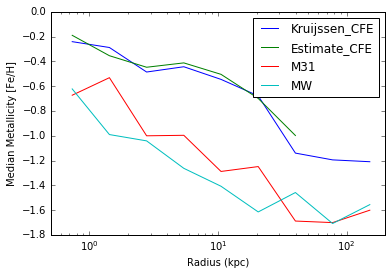

In [9]:
plt.plot((rbins[1:]+rbins[:-1])/2., metallicity_profile_wkcfe, label='Kruijssen_CFE')
plt.plot((rbins[1:]+rbins[:-1])/2., metallicity_profile_nokcfe, label='Estimate_CFE')
plt.plot((rbins[1:]+rbins[:-1])/2., m31_median_metalicity, label='M31')
plt.plot((rbins[1:]+rbins[:-1])/2., mw_median_metalicity, label='MW')
plt.xscale('log')
plt.xlim(rbins[0], rbins[-1])
plt.xlabel('Radius (kpc)')
plt.ylabel('Median Metallicity [Fe/H]')
plt.legend()
plt.show()